In [87]:
import torch
import torchvision
import torchvision.transforms as transforms

In [88]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [89]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 3)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(16, 32, 3)
        self.conv4 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(64 * 5 * 5, 4096)
        self.fc2 = nn.Linear(4096, 100)
        self.fc3 = nn.Linear(100, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x)) #30x30
        x = self.pool(F.relu(self.conv2(x))) #14x14
        x = F.relu(self.conv3(x)) #12x12
        x = self.pool(F.relu(self.conv4(x))) #5x5
        x = x.view(-1, 5*5*64)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x



In [90]:
import torch.optim as optim
import time
import os
import shutil
from torch.utils.tensorboard import SummaryWriter
NET_PATH = './cifar_net.pth'

# default `log_dir` is "runs" - we'll be more specific here

path = './runs/CIFAR10'
try:
    shutil.rmtree(path)
except OSError as e:
    print("Error: %s - %s." % (e.filename, e.strerror))
if os.path.exists(NET_PATH):
    os.remove(NET_PATH)
writer = SummaryWriter(path)

def train(device):
   
    
    net = Net().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    start = time.time()
    for epoch in range(2):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0
            if i % 1000 == 999:
                writer.add_scalar('training loss',
                            running_loss / 1000,
                            epoch * len(trainloader) + i)    

    end = time.time()
    print("train time on device: "+ device +" "+ str(end - start))
    print('Finished Training')
   
    torch.save(net.state_dict(), NET_PATH)

In [91]:
def test(device):
    net = Net().to(device)
    net.load_state_dict(torch.load(NET_PATH))
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))    

In [92]:
def testNew(device):
    net = Net().to(device)
    net.load_state_dict(torch.load(NET_PATH))
    correct = 0
    total = 0
    rightLabels = []
    wrongImages = []
    wrongLabels = []
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            values, indices = torch.topk(outputs.data, 3)
            _, predicted = torch.max(indices.data, 1)
            total += labels.size(0)
            for i in range(4):
                if labels[i] in indices[i]:
                     correct += 1
                else:
                    rightLabels.append(labels[i])
                    wrongImages.append(images[i])
                    wrongLabels.append(indices[i])
    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))   
    return rightLabels, wrongImages, wrongLabels 

In [93]:
train("cpu")

[1,  2000] loss: 2.289
[1,  4000] loss: 2.014
[1,  6000] loss: 1.793
[1,  8000] loss: 1.653
[1, 10000] loss: 1.595
[1, 12000] loss: 1.508
[2,  2000] loss: 1.408
[2,  4000] loss: 1.377
[2,  6000] loss: 1.330
[2,  8000] loss: 1.301
[2, 10000] loss: 1.263
[2, 12000] loss: 1.221
train time on device: cpu 876.4460043907166
Finished Training


In [94]:
train("cuda:0" if torch.cuda.is_available() else "cpu")

[1,  2000] loss: 2.303
[1,  4000] loss: 2.277
[1,  6000] loss: 1.971
[1,  8000] loss: 1.760
[1, 10000] loss: 1.634
[1, 12000] loss: 1.520
[2,  2000] loss: 1.401
[2,  4000] loss: 1.350
[2,  6000] loss: 1.287
[2,  8000] loss: 1.234
[2, 10000] loss: 1.189
[2, 12000] loss: 1.141
train time on device: cuda:0 144.44431710243225
Finished Training


In [95]:
test("cuda:0" if torch.cuda.is_available() else "cpu")

Accuracy of the network on the 10000 test images: 62 %


In [96]:
result = testNew("cuda:0" if torch.cuda.is_available() else "cpu")

Accuracy of the network on the 10000 test images: 87 %


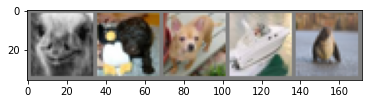

ship cat dog | deer horse cat | cat frog deer | cat dog bird | dog horse deer | 

In [97]:
import matplotlib.pyplot as plt
import numpy as np
import random

# functions to show an image

indices = [random.randrange(1, len(result[0]), 1) for i in range(5)]

def imshow(img):
    img = img.cpu()
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
imgs = [result[1][index] for index in indices]
imshow(torchvision.utils.make_grid(imgs))
labels = [classes[[result[0][index] for index in indices][j]] for j in range(5)]
wrongLabels = []
for i in range(5):
    wrongLabels.append([classes[[result[2][index] for index in indices][i][j]] for j in range(3)])
for i in range(5):
    print(' '.join(wrongLabels[i]), end=' | ') 

In [98]:
def matplotlib_imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def plot_img(images, labels, trueLabels):
    fig = plt.figure(figsize=(32, 32))
    for idx in np.arange(5):
        ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx])
        wrongLabels = ' '.join(labels[idx])
        ax.set_title("{0}, \n(label: {1})".format(
            trueLabels[idx],
            wrongLabels))
    return fig

writer.add_figure('Random wrong predicted images', plot_img(imgs, wrongLabels, labels))